In [3]:
import pandas as pd
import xgboost
import numpy as np
from sklearn.preprocessing import LabelEncoder

In [4]:
# The below files are as provided in the competition
print('Reading files')
df = pd.read_csv('train.csv')#train csv

atms = pd.read_csv('ATM_Info.csv')#ATM info csv

df_test_ = pd.read_csv('test.csv')#test csv

sub_re = pd.read_csv('Replenishment.csv')#Submission - Replenishment.csv

sub_with = pd.read_csv('Withdrawal.csv')#Submission - Withdrawal.csv

Reading files


In [5]:
def treat_df(df):
    df_new = df.copy()
    df_new = pd.merge(df, atms, on='ATM_ID', how='left')

    df_new['Date'] = pd.to_datetime(df_new.Date, format='%d-%b-%y')

    df_new['day']= df_new.Date.dt.day

    df_new['month'] = df_new.Date.dt.month

    df_new['year'] = df_new.Date.dt.year

    df_new['weekday'] = df_new.Date.dt.dayofweek

    df_new['day_of_year'] = df_new.Date.dt.dayofyear
    return df_new

In [6]:
print('Adding features...')
df_train = treat_df(df)

Adding features...


In [7]:
df_train.drop(['Balance'],1, inplace=True)

In [8]:
sub_with.columns = ['ID', 'ATM_ID', 'Date', 'Withdrawal']

In [9]:
df_test = treat_df(sub_with)

In [10]:
ulimit = df_train[['ATM_ID', 'Withdrawal']].groupby('ATM_ID').quantile(0.99).reset_index()

In [11]:
df_train = df_train.merge(ulimit, 'left', 'ATM_ID', suffixes=('', '_ulimit'))

In [12]:
df_train.drop(df_train.loc[df_train.Withdrawal>df_train.Withdrawal_ulimit, :].index, inplace=True)

In [13]:
df_train.drop(['Withdrawal_ulimit'],1,inplace=True)

In [14]:
df_train.index = range(df_train.shape[0])

In [15]:
df_mean = df_train.groupby('ATM_ID', as_index=False)['Withdrawal'].mean()

In [16]:
df_std = df_train[['ATM_ID', 'Withdrawal']].groupby('ATM_ID').std()['Withdrawal'].reset_index()

In [17]:
df_uq = df_train[['ATM_ID', 'Withdrawal']].groupby('ATM_ID').quantile(0.75).reset_index()
df_lq = df_train[['ATM_ID', 'Withdrawal']].groupby('ATM_ID').quantile(0.25).reset_index()

In [18]:
df_all = pd.concat([df_train, df_test])

In [19]:
df_all = df_all.merge(df_mean, 'left', 'ATM_ID', suffixes=('','_mean'))
df_all = df_all.merge(df_std, 'left', 'ATM_ID', suffixes=('','_std'))
df_all = df_all.merge(df_uq, 'left', 'ATM_ID', suffixes=('','_uq'))
df_all = df_all.merge(df_lq, 'left', 'ATM_ID', suffixes=('','_lq'))

In [20]:
le = LabelEncoder()

In [21]:
for col in df_all.columns:
    if col in ['Facility', 'Type']:
        df_all[col] = le.fit_transform(df_all[col])

In [22]:
print('Feature engineering done.')
print('Now training...This may take some time')

Feature engineering done.
Now training...This may take some time


In [23]:
xgb = xgboost.XGBRegressor(n_estimators=600, learning_rate=0.02, 
                           max_depth=10, silent=True, min_child_weight=6, 
                           subsample=0.8, colsample_bytree = 0.7, reg_lambda = 0.5)

In [24]:
df_train = df_all.loc[df_all.ID.isin(df.ID.unique()), :]

In [25]:
df_test = df_all.loc[df_all.ID.isin(df_test.ID.unique()), :]

In [26]:
predictors = df_train.columns.drop(['Date','ATM_ID', 'Withdrawal','ID'])

In [27]:
xgb.fit(df_train[predictors], df_train['Withdrawal'])

XGBRegressor(base_score=0.5, colsample_bylevel=1, colsample_bytree=0.7,
       gamma=0, learning_rate=0.02, max_delta_step=0, max_depth=10,
       min_child_weight=6, missing=None, n_estimators=600, nthread=-1,
       objective='reg:linear', reg_alpha=0, reg_lambda=0.5,
       scale_pos_weight=1, seed=0, silent=True, subsample=0.8)

In [28]:
df_test['Withdrawal'] = xgb.predict(df_test[predictors])

/home/aakash/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [29]:
df_test.loc[df_test.Withdrawal<0, 'Withdrawal'] = 0

/home/aakash/anaconda3/lib/python3.5/site-packages/pandas/core/indexing.py:465: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [30]:
print('Withdrawal predicted. Now optimizing for replenishment.')

Withdrawal predicted. Now optimizing for replenishment.


In [31]:
def cost_function(df_, strategy, repl_amount):
    df = df_.copy()
    #getting replenishment according to strategy
    if strategy==0:
        df['is_refilled'] = 0
        df['Replenishment'] = df['is_refilled']*repl_amount
    if strategy==1:
        df['is_refilled'] = 1
        df['Replenishment'] = df['is_refilled']*repl_amount
    if strategy==2:
        df['range_'] = range(len(df))
        df.loc[df.range_%2==0 , 'is_refilled'] = 1
        df.is_refilled.fillna(0, inplace=True)
        df['Replenishment'] = df['is_refilled']*repl_amount
    if strategy==3:
        df.loc[(df.weekday==0) | (df.weekday==3), 'is_refilled'] = 1
        df.is_refilled.fillna(0, inplace=True)
        df['Replenishment'] = df['is_refilled']*repl_amount
    if strategy==4:
        df.loc[df.weekday==3, 'is_refilled'] = 1
        df.is_refilled.fillna(0, inplace=True)
        df['Replenishment'] = df['is_refilled']*repl_amount
    if strategy==5:
        df.loc[df.weekday==0, 'is_refilled'] = 1
        df.is_refilled.fillna(0, inplace=True)
        df['Replenishment'] = df['is_refilled']*repl_amount
    if strategy==6:
        df.loc[df.weekday==3,'is_thursday'] = 1
        df.is_thursday.fillna(0, inplace=True)
        df['cumsum_thursday']  = df.is_thursday.cumsum()%2
        df['is_refilled'] = df.is_thursday*df.cumsum_thursday
        df['Replenishment'] = df.is_refilled*repl_amount
        df.drop(['cumsum_thursday', 'is_thursday'],1, inplace=True)
    #Calculating balance accroding to replenishment
    df['Difference'] = (df['Replenishment']-df['Withdrawal'])

    df['cumsum_is_refilled'] = df.is_refilled.cumsum()

    df['Balance'] = df.groupby('cumsum_is_refilled')['Difference'].cumsum()
    df.drop(['cumsum_is_refilled', 'Difference'], 1, inplace=True)
    
    #calculating cost
    #cost of filling
    cost_of_filling = df['is_refilled'].sum()*300
    #cost of cash
    costoofcash = (df.loc[df.Balance>0, 'Balance'].mean())*(0.15/12)
    cost_of_cash = 0 if np.isnan(costoofcash) else costoofcash
    #cost of stockout
    cos = df.loc[df.Balance<0, 'Balance'].count()
    cost_of_stockout = 0 if np.isnan(cos) else int(cos)*1000
    
    total_cost = cost_of_cash+cost_of_stockout+cost_of_filling
    
    return total_cost

In [32]:
def Optimize(df_exp):
#     all_cost = []
    optimum_repl = 0
    best_strategy = [0,0,cost_function(df_exp, 1,0)]
    for strat in range(1,7):
        min_ = cost_function(df_exp, strat, 0)
        cost = []
        for value in range(0, 200000, 1000):
            curr_cost = cost_function(df_exp, strat, value)
            if curr_cost<min_:
                min_ = curr_cost
                optimum_repl = value
#             if curr_cost>prev_cost:
#                 print('breaking at =', value)
#                 break
# #             cost.append(curr_cost)
#         print('Strategy =', strat,'Value = ', optimum_repl, 'Cost =',min_)
        if min_<best_strategy[2]:
            best_strategy = [strat, optimum_repl, min_]
#         all_cost.append(cost)
    return best_strategy

In [34]:
sol_re = pd.DataFrame(columns=['ATM_ID', 'Replenishment frequency', 'Replenishment amount'])

In [45]:
df_t = df_test.loc[df_test.ATM_ID=='SRNO00279', :]

In [69]:
%time
cost = []
for i in range(0,200000, 1000):
    cost.append((cost_function(df_t, 4, i)))

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 10.7 µs


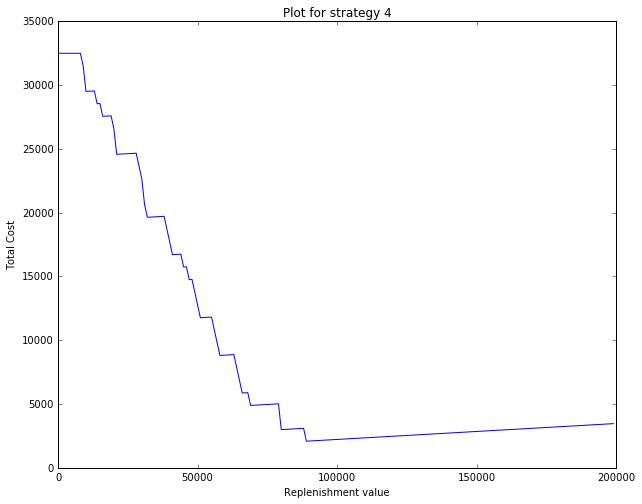

In [70]:
plt.figure(figsize=(10,8))
plt.plot(range(0,200000,1000), cost)
plt.xlabel('Replenishment value')
plt.ylabel('Total Cost')
plt.title('Plot for strategy 4')
plt.show()

In [ ]:
counter=0
for atm in df_test.ATM_ID.unique():
    df_temp = df_test.loc[df_test.ATM_ID==atm, :]
    counter+=1
    print('Optimizing for ATM_ID :', atm, 479-counter, 'optimizations left', end='\r')
    curr_best = Optimize(df_temp)
    atm_sol = pd.Series({'ATM_ID':atm, 'Replenishment frequency':curr_best[0],'Replenishment amount':curr_best[1]})
    sol_re = sol_re.append(atm_sol,ignore_index=True)

In [ ]:
sol_re.to_csv('Solution_Replenishment.csv', index=False)#should be renamed to Withdrawal.csv for submission

In [ ]:
sol_with = df_test[['ID', 'ATM_ID','Date' ,'Withdrawal']]

In [ ]:
sol_with.columns = [['ID', 'ATM_ID', 'DATE', 'WITHDRAWAL']]

In [ ]:
sol_with.to_csv('Solution_Withdrawal.csv', index=False)#should be renamed to Withdrawal.csv for submission